In [1]:
%%capture
!pip install tensorflow_addons
!pip install tensorflow_text

In [2]:
import numpy as np
import pandas as pd
import random, io, os, datetime, glob
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
print('Tensorflow Hub version: {}'.format(hub.__version__))

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

!nvidia-smi

Tensorflow version: 2.9.1
Tensorflow Hub version: 0.12.0
Mon Jun 27 08:39:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                               

## Hyperparameters

In [ ]:
BATCH_SIZE = 128

## Load data

Number of news: 200853
Number of min, max, avg characters in "headline_char_len" column: 0, 320, 57
Number of min, max, avg words in "headline_word_len" column: 0, 44, 9
1269                Corruption Is Bad
1888               Meeting Mr. Wright
4975      Re-Introducing The Flipside
7650                   Truth And Lies
7776                    An NRA World?
                     ...             
200751            Darkness Ain't Cool
200759          Creating Shared Value
200803                   On the Fence
200819             Femme Invisibility
200845                       Web Wars
Name: headline, Length: 5022, dtype: object
Number of headlines less than threshold 5022


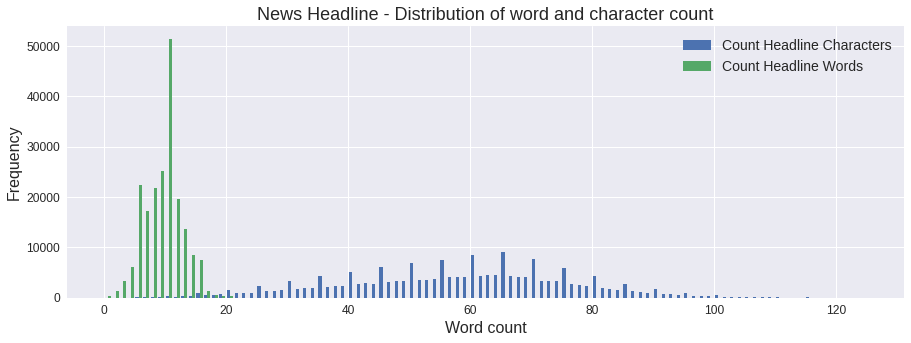

 
Number of min, max, avg characters in "short_description_char_len" column: 0, 1472, 114
Number of min, max, avg words in "short_description_word_len" column: 0, 243, 19
         short_description        category
69        Can you believe?    QUEER VOICES
105            What a god.   ENTERTAINMENT
114     "Pot meet kettle."        POLITICS
141                    😻😻😻      WEIRD NEWS
164      Under $1 million?          COMEDY
...                    ...             ...
198250                        QUEER VOICES
198265                         ENVIRONMENT
200129                              IMPACT
200191                        QUEER VOICES
200266                      STYLE & BEAUTY

[24297 rows x 2 columns]
Number of short_descriptions less than threshold 24297


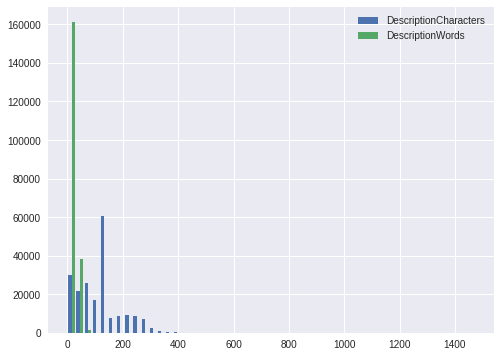

 
Number of min, max, avg characters in "headline_description_char_len" column: 2, 1488, 174
Number of min, max, avg words in "headline_description_word_len" column: 1, 245, 29
                                     headline_description        category
448     Chrissy Teigen And John Legend Welcome Baby Bo...   ENTERTAINMENT
845     This 'Pollen Bomb' Is Every Allergy Sufferer's...      WEIRD NEWS
1690    'Family Guy' Wickedly Pranks Emmy Voters. We h...   ENTERTAINMENT
2319    4 Notorious Hurricane Names You'll Never Hear ...      WORLD NEWS
3426    'The Simpsons' Predicted The Downfall Of Toys ...   ENTERTAINMENT
...                                                   ...             ...
185958  Watermelon Recipes To Eat All Summer Long. You...    FOOD & DRINK
186031  How To BBQ: Grill Anything Safely. Courtesy of...        WELLNESS
189660  A Landscape of Irrational Exuberance: This Art...  CULTURE & ARTS
192040  Parenting After Divorce. Parenting changes aft...         DIVORCE
195169  H

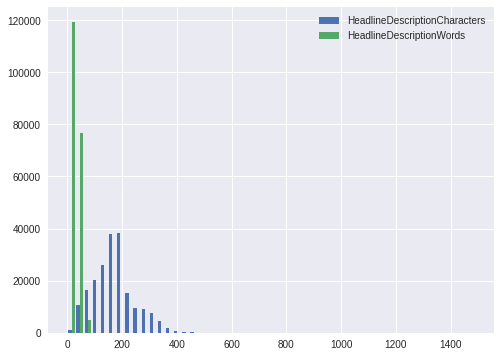

 
Max category id: 40
Unique categories: 41
 


,category,headline,authors,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
df = pd.read_json('/content/drive/MyDrive/Capital_Market/Neural_Returns/Demo_Data/NLP_Classification/HuffPost_News/News_Category_Dataset_v2.json', lines=True)
df_original = df[['category','headline','authors','short_description','date']]

df['category_id'] = pd.factorize(df['category'])[0]
df['headline_char_len'] = df['headline'].str.len()
df['headline_word_len'] = df['headline'].str.split().apply(len)
df['short_description_char_len'] = df['short_description'].str.len()
df['short_description_word_len'] = df['short_description'].str.split().apply(len)

df['headline_description'] = df['headline'] + '. ' + df['short_description']
df['headline_description_char_len'] = df['headline_description'].str.len()
df['headline_description_word_len'] = df['headline_description'].str.split().apply(len)

print('Number of news:', len(df))
print('=================================')
print('Number of min, max, avg characters in "headline_char_len" column: {}, {}, {}'.format(df['headline_char_len'].min(), df['headline_char_len'].max(), int(df['headline_char_len'].mean())))
print('Number of min, max, avg words in "headline_word_len" column: {}, {}, {}'.format(df['headline_word_len'].min(), df['headline_word_len'].max(), int(df['headline_word_len'].mean())))
print('=================================')
print(df.loc[df['headline_word_len'] <= 3]['headline'])
print('Number of headlines less than threshold', len(df.loc[df['headline_word_len'] <= 3]))

plt.figure(figsize=(15,5))
plt.title('News Headline - Distribution of word and character count', fontsize=18)
plt.hist([df['headline_char_len'], df['headline_word_len']], 100, label=['Count Headline Characters', 'Count Headline Words'], range=(0, 125))
plt.ylabel('Frequency', fontsize=16)
plt.yticks(fontsize=12)
plt.xlabel("Word count", fontsize=16)
plt.xticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
plt.show()
print('==================================================================')
print(' ')

print('Number of min, max, avg characters in "short_description_char_len" column: {}, {}, {}'.format(df['short_description_char_len'].min(), df['short_description_char_len'].max(), int(df['short_description_char_len'].mean())))
print('Number of min, max, avg words in "short_description_word_len" column: {}, {}, {}'.format(df['short_description_word_len'].min(), df['short_description_word_len'].max(), int(df['short_description_word_len'].mean())))
print('=================================')
print(df.loc[df['short_description_word_len'] <= 3][['short_description', 'category']])
print('Number of short_descriptions less than threshold', len(df.loc[df['short_description_word_len'] <= 3]))
plt.figure(figsize=(8,6))
plt.hist([df['short_description_char_len'], df['short_description_word_len']], 50, label=['DescriptionCharacters', 'DescriptionWords'])
plt.legend(loc='upper right')
plt.show()
print('==================================================================')
print(' ')

print('Number of min, max, avg characters in "headline_description_char_len" column: {}, {}, {}'.format(df['headline_description_char_len'].min(), df['headline_description_char_len'].max(), int(df['headline_description_char_len'].mean())))
print('Number of min, max, avg words in "headline_description_word_len" column: {}, {}, {}'.format(df['headline_description_word_len'].min(), df['headline_description_word_len'].max(), int(df['headline_description_word_len'].mean())))
print('=================================')
print(df.loc[df['headline_description_word_len'] == 10][['headline_description', 'category']])
print('Number of short_descriptions less than threshold', len(df.loc[df['headline_description_word_len'] == 10]))
plt.figure(figsize=(8,6))
plt.hist([df['headline_description_char_len'], df['headline_description_word_len']], 50, label=['HeadlineDescriptionCharacters', 'HeadlineDescriptionWords'])
plt.legend(loc='upper right')
plt.show()
print('==================================================================')
print(' ')
print('Max category id: {}'.format(df['category_id'].max()))
print('Unique categories: {}'.format(len(df['category'].unique())))
print(' ')
df_original.head()

## Clean data - Remove non-wanted records

Number of total news records: 189339
               category_id
                     count
category                  
ARTS                  1236
ARTS & CULTURE        1338
BLACK VOICES          4328
BUSINESS              5400
COLLEGE               1042
COMEDY                4637
CRIME                 2969
CULTURE & ARTS        1014
DIVORCE               3426
EDUCATION              934
ENTERTAINMENT        14494
ENVIRONMENT           1321
FIFTY                 1189
FOOD & DRINK          6157
GOOD NEWS             1291
GREEN                 2299
HEALTHY LIVING        5742
HOME & LIVING         4180
IMPACT                3305
LATINO VOICES         1087
MEDIA                 2467
MONEY                 1706
PARENTING             8671
PARENTS               3741
POLITICS             31034
QUEER VOICES          6027
RELIGION              2151
SCIENCE               1901
SPORTS                4440
STYLE                 1839
STYLE & BEAUTY        9630
TASTE                 1977
TECH              

,category,headline,authors,link,short_description,date,category_id,headline_char_len,headline_word_len,short_description_char_len,short_description_word_len,headline_description,headline_description_char_len,headline_description_word_len
189334,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28,14,58,8,124,18,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,184,26
189335,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28,10,69,10,122,20,Maria Sharapova Stunned By Victoria Azarenka I...,193,30
189336,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28,10,99,16,121,24,"Giants Over Patriots, Jets Over Colts Among M...",222,40
189337,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28,10,53,8,120,20,Aldon Smith Arrested: 49ers Linebacker Busted ...,175,28
189338,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28,10,56,9,122,19,Dwight Howard Rips Teammates After Magic Loss ...,180,28


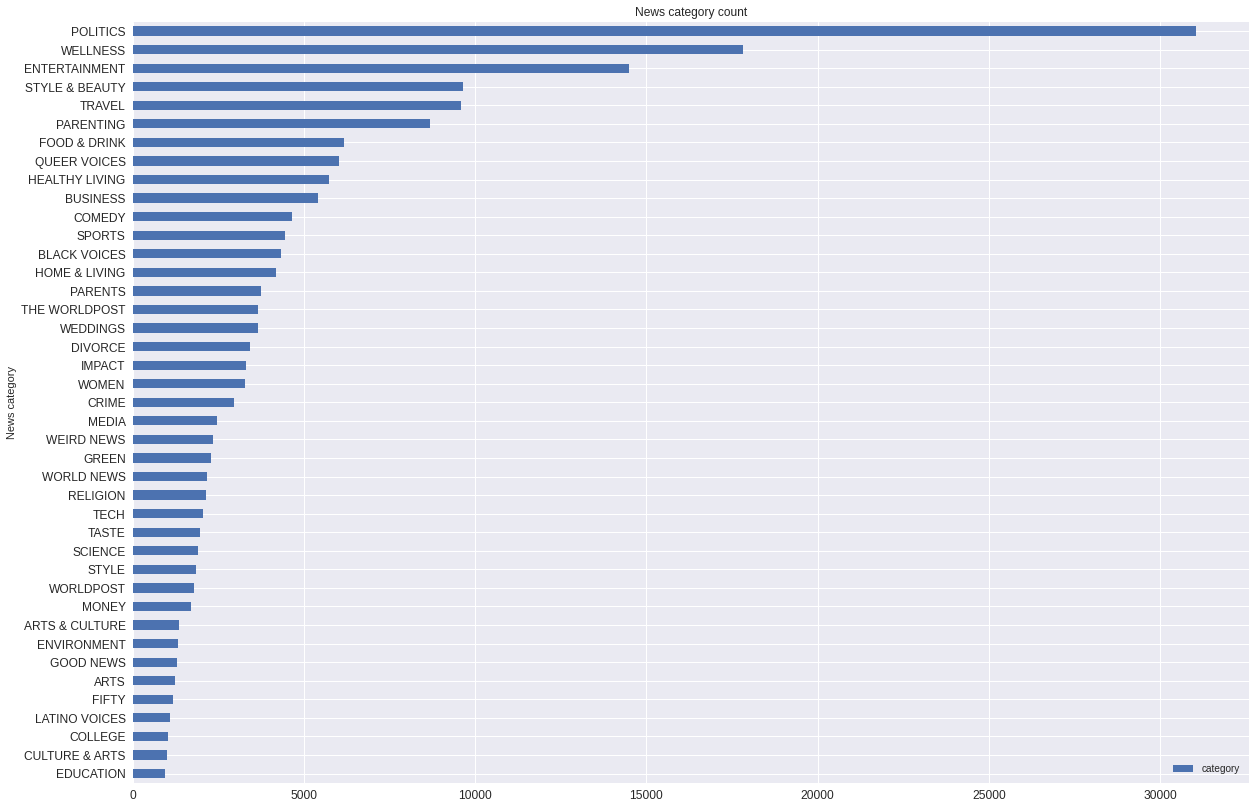

In [4]:
#Remove sequences which are too short
df = df[df['headline_description_word_len'] >= 10]
df.reset_index(drop=True, inplace=True)

print('Number of total news records: {}'.format(len(df)))
print(df.groupby('category').agg({'category_id':['count'],}))
print(df.groupby('category').count()['category_id']/len(df))

df.category.value_counts().sort_values().plot(kind='barh', figsize=(20,14), title='News category count', legend='Number of news records per category', xlabel='News category', ylabel='Count', fontsize=12)

df.tail()

## Clean data - Remove non-wanted records

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


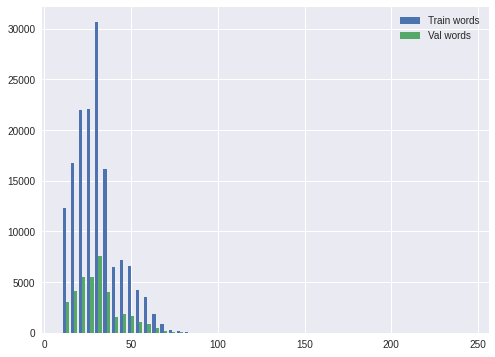

Category IDs
category        category_id
ARTS            30               989
ARTS & CULTURE  21              1064
BLACK VOICES    6               3484
BUSINESS        11              4300
COLLEGE         19               849
COMEDY          8               3707
CRIME           0               2354
CULTURE & ARTS  40               825
DIVORCE         35              2736
EDUCATION       18               746
ENTERTAINMENT   1              11682
ENVIRONMENT     39              1039
FIFTY           29               947
FOOD & DRINK    37              5001
GOOD NEWS       27              1043
GREEN           23              1842
HEALTHY LIVING  25              4626
HOME & LIVING   33              3349
IMPACT          3               2644
LATINO VOICES   17               868
MEDIA           13              1981
MONEY           38              1361
PARENTING       32              6838
PARENTS         20              2989
POLITICS        4              24803
QUEER VOICES    9               47

In [5]:
df_train = df.sample(frac=0.8, random_state=3, replace=False)
df_val = df.drop(df_train.index)

df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)

plt.figure(figsize=(8,6))
plt.hist([df_train['headline_description_word_len'], df_val['headline_description_word_len']], 50, label=['Train words', 'Val words'])
plt.legend(loc='upper right')
plt.show()

print('Category IDs')
print(df_train.groupby(['category','category_id']).size())
print('==============================================================')
print('Class distribution')
class_distribution = df_train.groupby('category').count()['category_id']/df_train.groupby('category').count().sum()[0]
print('Number of classes: {}'.format(len(class_distribution)))
print(class_distribution)
print('==============================================================')

print('Number of unique categories: {}'.format(len(df_train['category_id'].unique())))
print(sorted(df_train['category_id'].unique()))
print(sorted(df_val['category_id'].unique()))


print('Reversed class distribution named')
reverese_class_distribution = (1/(df_train.groupby('category').count()['category_id']/df_train.groupby('category').count().sum()[0]))
reverse_sum = 1/reverese_class_distribution.sum()
scaled_reverese_class_dist = reverese_class_distribution * reverse_sum
print(scaled_reverese_class_dist)
print(scaled_reverese_class_dist.sum())
print('==============================================================')


## Generate sample dataset with equal class distribution

In [6]:
df_sample = df_val.groupby('category').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop = True)

print('Category IDs')
print(df_sample.groupby(['category','category_id']).size().reset_index().rename(columns={0:'count'}).sort_values(by='category_id'))

Category IDs
          category  category_id  count
6            CRIME            0    200
10   ENTERTAINMENT            1    200
39      WORLD NEWS            2    200
18          IMPACT            3    200
24        POLITICS            4    200
36      WEIRD NEWS            5    200
2     BLACK VOICES            6    200
38           WOMEN            7    200
5           COMEDY            8    200
25    QUEER VOICES            9    200
28          SPORTS           10    200
3         BUSINESS           11    200
34          TRAVEL           12    200
20           MEDIA           13    200
32            TECH           14    200
26        RELIGION           15    200
27         SCIENCE           16    200
19   LATINO VOICES           17    200
9        EDUCATION           18    200
4          COLLEGE           19    200
23         PARENTS           20    200
1   ARTS & CULTURE           21    200
29           STYLE           22    200
15           GREEN           23    200
31          

## Load ALBERT tokenizer and define data generator

In [ ]:
#Load albert tokenizer
albert_tokenizer = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3")

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, data, tokenizer, batch_size, shuffle=True):
    self.data = data
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return (np.ceil(len(self.data) / float(self.batch_size))).astype(np.int)

  def __getitem__(self, idx):
    df_batch = self.data.iloc[idx*self.batch_size : ((idx+1)*self.batch_size)]
    preprocessed_tokens = self.tokenizer(tf.constant(df_batch['headline_description'].tolist())) 
    y = df_batch['category_id'].values
    return [preprocessed_tokens['input_word_ids'], preprocessed_tokens['input_mask'], preprocessed_tokens['input_type_ids']], y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.data))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

In [10]:
#Initalize data generator
sample_predGen = DataGenerator(df_sample, albert_tokenizer, BATCH_SIZE, shuffle=False)
val_predGen = DataGenerator(df_val, albert_tokenizer, BATCH_SIZE, shuffle=False)

## Load models and generate predictions

### Load FROZEN ALBERT as "layer model"

In [11]:
#Load model
layer_model = tf.keras.models.load_model('/content/drive/MyDrive/Capital_Market/Medium_Tutorials/Medium-Part3/CompareClassifier/Models/20210608_AlbertBase_TextClassifier_ClassificationLayerOnly_epoch21_val-loss2.356750.hdf5', custom_objects={'KerasLayer': hub.KerasLayer})

#Calculate predication for sample from validation set
layer_sample_pred = layer_model.predict(sample_predGen)
layer_val_pred = layer_model.predict(val_predGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 374s 1s/step


### Load TRAINED ALBERT as "full model"


In [12]:
#Load model
full_model = tf.keras.models.load_model('/content/drive/MyDrive/Capital_Market/Medium_Tutorials/Medium-Part3/CompareClassifier/Models/20210611_AlbertBase_Phase3_FullTraining_epoch07_val-loss1.488425.hdf5', custom_objects={'KerasLayer': hub.KerasLayer})

#Calculate predication for sample from validation set
full_sample_pred = full_model.predict(sample_predGen)
full_val_pred = full_model.predict(val_predGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 402s 1s/step


### Load SIAMESE ALBERT


In [13]:
#Load model
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Capital_Market/Medium_Tutorials/Medium-Part3/CompareClassifier/Models/20210611_AlbertBase_SiameseTextClassifierPhase1_epoch38_val-loss1.539364.hdf5', custom_objects={'KerasLayer': hub.KerasLayer})

#Calculate predication for sample from validation set
siamese_sample_pred = siamese_model.predict(sample_predGen)
siamese_val_pred = siamese_model.predict(val_predGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 414s 1s/step


## Model summaries

### FROZEN ALBERT summary

In [14]:
layer_model.summary()

Model: "BaseClassifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'default': (None,   11683584    ['input_2[0][0]',                
                                768),                             'input_3[0][0

### TRAINED ALBERT summary

In [15]:
full_model.summary()

Model: "BaseClassifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'encoder_outputs':  11683584    ['input_2[0][0]',                
                                 [(None, 128, 768),               'input_3[0][0

### SIAMESE ALBERT summary

In [16]:
siamese_model.summary()

Model: "SiameseClassifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'pooled_output': (  11683584    ['input_5[0][0]',                
                                None, 768),                       'input_6[0

## Initial evaluation

In [ ]:
val_predGen = DataGenerator(df_val, albert_tokenizer, BATCH_SIZE, shuffle=False)
layer_eval = layer_model.evaluate(val_predGen)
layer_eval

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 321s 1s/step - loss: 2.3567 - accuracy: 0.3224


[2.3567450046539307, 0.32240942120552063]

In [ ]:
val_predGen = DataGenerator(df_val, albert_tokenizer, BATCH_SIZE, shuffle=False)
full_eval = full_model.evaluate(val_predGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 322s 1s/step - loss: 1.4884 - accuracy: 0.5807


In [ ]:
val_predGen = DataGenerator(df_val, albert_tokenizer, BATCH_SIZE, shuffle=False)
siamese_eval = siamese_model.evaluate(val_predGen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


296/296 [==============================] - 349s 1s/step - loss: 1.5394 - accuracy: 0.6298


## Performance metrics

In [17]:
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_sample['category_id'].ravel(), axis=-1), layer_sample_pred)
print('Sample data sparse categorical accuracy - FROZEN ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_val['category_id'].ravel(), axis=-1), layer_val_pred)
print('Validation data sparse categorical accuracy - FROZEN ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))
print(' ')

metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_sample['category_id'].ravel(), axis=-1), full_sample_pred)
print('Sample data sparse categorical accuracy - TRAINED ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_val['category_id'].ravel(), axis=-1), full_val_pred)
print('Validation data sparse categorical accuracy - TRAINED ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))
print(' ')

metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_sample['category_id'].ravel(), axis=-1), siamese_sample_pred)
print('Sample data sparse categorical accuracy - Siamese ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
metrics.update_state(np.expand_dims(df_val['category_id'].ravel(), axis=-1), siamese_val_pred)
print('Validation data sparse categorical accuracy - Siamese ALBERT Model: {0:0.3f}'.format(metrics.result().numpy()))

Sample data sparse categorical accuracy - FROZEN ALBERT Model: 0.314
Validation data sparse categorical accuracy - FROZEN ALBERT Model: 0.322
 
Sample data sparse categorical accuracy - TRAINED ALBERT Model: 0.562
Validation data sparse categorical accuracy - TRAINED ALBERT Model: 0.581
 
Sample data sparse categorical accuracy - Siamese ALBERT Model: 0.522
Validation data sparse categorical accuracy - Siamese ALBERT Model: 0.630


### FROZEN ALBERT - Detailed metrics

In [21]:
print(classification_report(df_sample['category_id'].ravel(), layer_sample_pred.argmax(axis=1)))
print(' ')
print('===============================================================')
print(' ')
print(classification_report(df_val['category_id'].ravel(), layer_val_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.60      0.53       200
           1       0.24      0.38      0.29       200
           2       0.33      0.31      0.32       200
           3       0.23      0.19      0.21       200
           4       0.34      0.32      0.33       200
           5       0.31      0.28      0.29       200
           6       0.14      0.13      0.13       200
           7       0.10      0.03      0.05       200
           8       0.25      0.31      0.28       200
           9       0.15      0.12      0.13       200
          10       0.51      0.57      0.54       200
          11       0.26      0.10      0.14       200
          12       0.39      0.36      0.38       200
          13       0.23      0.41      0.29       200
          14       0.40      0.34      0.36       200
          15       0.40      0.20      0.27       200
          16       0.46      0.34      0.39       200
          17       0.06    

### TRAINED ALBERT - Detailed metrics

In [23]:
print(classification_report(df_sample['category_id'].ravel(), full_sample_pred.argmax(axis=1)))
print(' ')
print('===============================================================')
print(' ')
print(classification_report(df_val['category_id'].ravel(), full_val_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       200
           1       0.44      0.49      0.46       200
           2       0.44      0.44      0.44       200
           3       0.38      0.34      0.36       200
           4       0.49      0.49      0.49       200
           5       0.46      0.41      0.43       200
           6       0.47      0.56      0.51       200
           7       0.48      0.43      0.46       200
           8       0.47      0.52      0.50       200
           9       0.55      0.75      0.63       200
          10       0.67      0.77      0.72       200
          11       0.42      0.47      0.45       200
          12       0.65      0.70      0.67       200
          13       0.64      0.59      0.62       200
          14       0.68      0.56      0.61       200
          15       0.59      0.64      0.61       200
          16       0.71      0.59      0.64       200
          17       0.67    

### Siamese ALBERT - Detailed metrics

In [24]:
print(classification_report(df_sample['category_id'].ravel(), siamese_sample_pred.argmax(axis=1)))
print(' ')
print('===============================================================')
print(' ')
print(classification_report(df_val['category_id'].ravel(), siamese_val_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.53      0.61      0.57       200
           1       0.40      0.70      0.51       200
           2       0.30      0.23      0.26       200
           3       0.27      0.28      0.27       200
           4       0.36      0.75      0.49       200
           5       0.36      0.28      0.31       200
           6       0.53      0.30      0.38       200
           7       0.34      0.28      0.31       200
           8       0.52      0.45      0.48       200
           9       0.75      0.66      0.70       200
          10       0.71      0.80      0.75       200
          11       0.46      0.52      0.49       200
          12       0.63      0.84      0.72       200
          13       0.64      0.52      0.57       200
          14       0.60      0.56      0.58       200
          15       0.63      0.52      0.57       200
          16       0.59      0.51      0.55       200
          17       0.63    

## ROC - AUC Sample dataset

In [25]:
y_hot_encoded = label_binarize(df_sample['category_id'], classes=range(len(df_sample['category_id'].unique())))
layer_sample_fpr, layer_sample_tpr, layer_sample_roc_auc = dict(), dict(), dict()
full_sample_fpr, full_sample_tpr, full_sample_roc_auc = dict(), dict(), dict()
siamese_sample_fpr, siamese_sample_tpr, siamese_sample_roc_auc = dict(), dict(), dict()

for i in range(len(df_sample['category_id'].unique())):
  layer_sample_fpr[i], layer_sample_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=layer_sample_pred[:, i], pos_label=1)
  layer_sample_roc_auc[i] = auc(layer_sample_fpr[i], layer_sample_tpr[i])
  
for i in range(len(df_sample['category_id'].unique())):
  full_sample_fpr[i], full_sample_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=full_sample_pred[:, i], pos_label=1)
  full_sample_roc_auc[i] = auc(full_sample_fpr[i], full_sample_tpr[i])

for i in range(len(df_sample['category_id'].unique())):
  siamese_sample_fpr[i], siamese_sample_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=siamese_sample_pred[:, i], pos_label=1)
  siamese_sample_roc_auc[i] = auc(siamese_sample_fpr[i], siamese_sample_tpr[i])  

# Compute micro-average ROC curve and ROC area
layer_sample_fpr["micro"], layer_sample_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), layer_sample_pred.ravel())
layer_sample_roc_auc["micro"] = auc(layer_sample_fpr["micro"], layer_sample_tpr["micro"])  

full_sample_fpr["micro"], full_sample_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), full_sample_pred.ravel())
full_sample_roc_auc["micro"] = auc(full_sample_fpr["micro"], full_sample_tpr["micro"]) 

siamese_sample_fpr["micro"], siamese_sample_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), siamese_sample_pred.ravel())
siamese_sample_roc_auc["micro"] = auc(siamese_sample_fpr["micro"], siamese_sample_tpr["micro"]) 

#Aggregate all false positive rates
all_layer_sample_fpr = np.unique(np.concatenate([layer_sample_fpr[i] for i in range(len(df_sample['category_id'].unique()))]))
all_full_sample_fpr = np.unique(np.concatenate([full_sample_fpr[i] for i in range(len(df_sample['category_id'].unique()))]))
all_siamese_sample_fpr = np.unique(np.concatenate([siamese_sample_fpr[i] for i in range(len(df_sample['category_id'].unique()))]))

#Then interpolate all ROC curves at this points
mean_layer_sample_tpr = np.zeros_like(all_layer_sample_fpr)
mean_full_sample_tpr = np.zeros_like(all_full_sample_fpr)
mean_siamese_sample_tpr = np.zeros_like(all_siamese_sample_fpr)
for i in range(len(df_sample['category_id'].unique())):
    mean_layer_sample_tpr += np.interp(all_layer_sample_fpr, layer_sample_fpr[i], layer_sample_tpr[i])
    mean_full_sample_tpr += np.interp(all_full_sample_fpr, full_sample_fpr[i], full_sample_tpr[i])
    mean_siamese_sample_tpr += np.interp(all_siamese_sample_fpr, siamese_sample_fpr[i], siamese_sample_tpr[i])

#Average it and compute AUC
mean_layer_sample_tpr /= len(df_sample['category_id'].unique())
mean_full_sample_tpr /= len(df_sample['category_id'].unique())
mean_siamese_sample_tpr /= len(df_sample['category_id'].unique())

layer_sample_fpr["macro"], layer_sample_tpr["macro"] = all_layer_sample_fpr, mean_layer_sample_tpr
full_sample_fpr["macro"], full_sample_tpr["macro"] = all_full_sample_fpr, mean_full_sample_tpr
siamese_sample_fpr["macro"], siamese_sample_tpr["macro"] = all_siamese_sample_fpr, mean_siamese_sample_tpr

layer_sample_roc_auc["macro"] = auc(layer_sample_fpr["macro"], layer_sample_tpr["macro"])
full_sample_roc_auc["macro"] = auc(full_sample_fpr["macro"], full_sample_tpr["macro"])    
siamese_sample_roc_auc["macro"] = auc(siamese_sample_fpr["macro"], siamese_sample_tpr["macro"])    

### FROZEN ALBERT model - ROC curve

AUC for class 0: 0.9451862499999999
AUC for class 1: 0.9044806249999999
AUC for class 2: 0.9355475
AUC for class 3: 0.83668875
AUC for class 4: 0.917475625
AUC for class 5: 0.91862375
AUC for class 6: 0.8028412500000001
AUC for class 7: 0.808909375
AUC for class 8: 0.87870875
AUC for class 9: 0.7781737500000001
AUC for class 10: 0.9356475
AUC for class 11: 0.84889
AUC for class 12: 0.8780475
AUC for class 13: 0.8874949999999999
AUC for class 14: 0.870243125
AUC for class 15: 0.8552825
AUC for class 16: 0.929174375
AUC for class 17: 0.8288125
AUC for class 18: 0.90648375
AUC for class 19: 0.8699987499999999
AUC for class 20: 0.882265
AUC for class 21: 0.88804875
AUC for class 22: 0.907144375
AUC for class 23: 0.852840625
AUC for class 24: 0.9437706250000001
AUC for class 25: 0.8698112499999999
AUC for class 26: 0.9496568749999998
AUC for class 27: 0.87822
AUC for class 28: 0.9576218750000001
AUC for class 29: 0.93548375
AUC for class 30: 0.9488187499999999
AUC for class 31: 0.8880349999

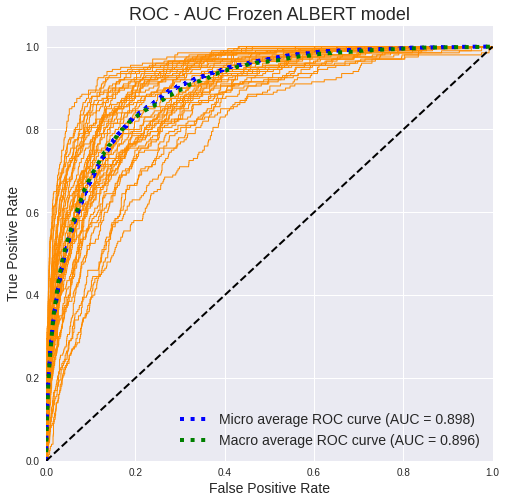

In [38]:
plt.figure(figsize=(8,8))

for i in range(len(df_sample['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, layer_sample_roc_auc[i]))
  plt.plot(layer_sample_fpr[i], layer_sample_tpr[i], color='darkorange',
          lw=1)

plt.plot(layer_sample_fpr["micro"], layer_sample_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(layer_sample_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(layer_sample_fpr["macro"], layer_sample_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(layer_sample_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC - AUC Frozen ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Trained ALBERT model - ROC Curve

AUC for class 0: 0.96431
AUC for class 1: 0.9444093749999999
AUC for class 2: 0.960603125
AUC for class 3: 0.896405
AUC for class 4: 0.949646875
AUC for class 5: 0.9516256249999999
AUC for class 6: 0.9221475
AUC for class 7: 0.942359375
AUC for class 8: 0.934144375
AUC for class 9: 0.947175
AUC for class 10: 0.98077375
AUC for class 11: 0.9296875
AUC for class 12: 0.976291875
AUC for class 13: 0.9571118750000001
AUC for class 14: 0.9476668749999999
AUC for class 15: 0.965225625
AUC for class 16: 0.9588693749999999
AUC for class 17: 0.9464031249999999
AUC for class 18: 0.95147375
AUC for class 19: 0.9268087500000001
AUC for class 20: 0.96420375
AUC for class 21: 0.9408118750000001
AUC for class 22: 0.9660706250000001
AUC for class 23: 0.9450812499999999
AUC for class 24: 0.974119375
AUC for class 25: 0.9423418749999999
AUC for class 26: 0.967443125
AUC for class 27: 0.91070125
AUC for class 28: 0.9779231249999999
AUC for class 29: 0.955055
AUC for class 30: 0.939338125
AUC for class 31:

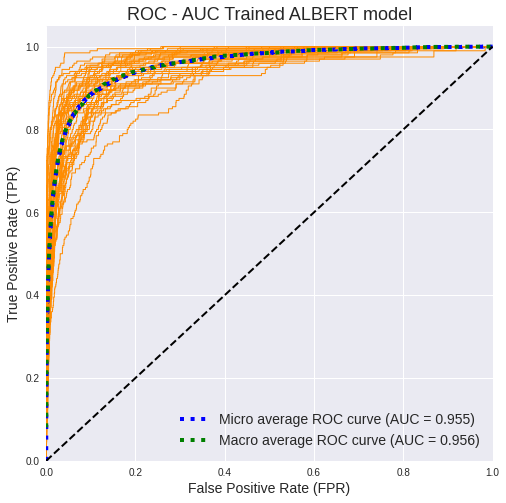

In [39]:
plt.figure(figsize=(8,8))

for i in range(len(df_sample['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, full_sample_roc_auc[i]))
  plt.plot(full_sample_fpr[i], full_sample_tpr[i], color='darkorange',
          lw=1)

plt.plot(full_sample_fpr["micro"], full_sample_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(full_sample_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(full_sample_fpr["macro"], full_sample_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(full_sample_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC - AUC Trained ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Siamese ALBERT model - ROC Curve

AUC for class 0: 0.9539599999999999
AUC for class 1: 0.9433525
AUC for class 2: 0.9352499999999999
AUC for class 3: 0.8724193750000001
AUC for class 4: 0.96181125
AUC for class 5: 0.9180456250000001
AUC for class 6: 0.865469375
AUC for class 7: 0.86078875
AUC for class 8: 0.9245162499999999
AUC for class 9: 0.92950625
AUC for class 10: 0.9776325
AUC for class 11: 0.92051125
AUC for class 12: 0.9838162500000001
AUC for class 13: 0.95117875
AUC for class 14: 0.9241725000000001
AUC for class 15: 0.923763125
AUC for class 16: 0.947465
AUC for class 17: 0.916888125
AUC for class 18: 0.94414125
AUC for class 19: 0.9108756250000001
AUC for class 20: 0.945441875
AUC for class 21: 0.90477875
AUC for class 22: 0.9468118750000001
AUC for class 23: 0.9260468749999999
AUC for class 24: 0.9574318749999999
AUC for class 25: 0.928505625
AUC for class 26: 0.9512512499999999
AUC for class 27: 0.8888206249999999
AUC for class 28: 0.948495
AUC for class 29: 0.9037599999999999
AUC for class 30: 0.942064999

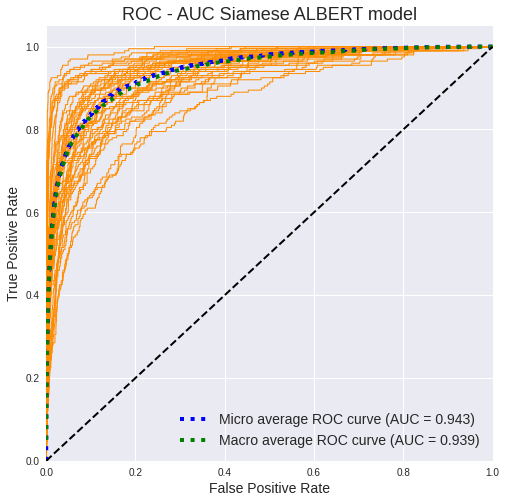

In [41]:
plt.figure(figsize=(8,8))

for i in range(len(df_sample['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, siamese_sample_roc_auc[i]))
  plt.plot(siamese_sample_fpr[i], siamese_sample_tpr[i], color='darkorange',
          lw=1)

plt.plot(siamese_sample_fpr["micro"], siamese_sample_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(siamese_sample_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(siamese_sample_fpr["macro"], siamese_sample_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(siamese_sample_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC - AUC Siamese ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## ROC - AUC Validation dataset

In [27]:
y_hot_encoded = label_binarize(df_val['category_id'], classes=range(len(df_val['category_id'].unique())))

layer_val_fpr, layer_val_tpr, layer_val_roc_auc = dict(), dict(), dict()
full_val_fpr, full_val_tpr, full_val_roc_auc = dict(), dict(), dict()
siamese_val_fpr, siamese_val_tpr, siamese_val_roc_auc = dict(), dict(), dict()

for i in range(len(df_val['category_id'].unique())):
  layer_val_fpr[i], layer_val_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=layer_val_pred[:, i], pos_label=1)
  layer_val_roc_auc[i] = auc(layer_val_fpr[i], layer_val_tpr[i])
  
for i in range(len(df_val['category_id'].unique())):
  full_val_fpr[i], full_val_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=full_val_pred[:, i], pos_label=1)
  full_val_roc_auc[i] = auc(full_val_fpr[i], full_val_tpr[i])

for i in range(len(df_val['category_id'].unique())):
  siamese_val_fpr[i], siamese_val_tpr[i], _ = roc_curve(y_true=y_hot_encoded[:, i], y_score=siamese_val_pred[:, i], pos_label=1)
  siamese_val_roc_auc[i] = auc(siamese_val_fpr[i], siamese_val_tpr[i])  

# Compute micro-average ROC curve and ROC area
layer_val_fpr["micro"], layer_val_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), layer_val_pred.ravel())
layer_val_roc_auc["micro"] = auc(layer_val_fpr["micro"], layer_val_tpr["micro"])  

full_val_fpr["micro"], full_val_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), full_val_pred.ravel())
full_val_roc_auc["micro"] = auc(full_val_fpr["micro"], full_val_tpr["micro"]) 

siamese_val_fpr["micro"], siamese_val_tpr["micro"], _ = roc_curve(y_hot_encoded.ravel(), siamese_val_pred.ravel())
siamese_val_roc_auc["micro"] = auc(siamese_val_fpr["micro"], siamese_val_tpr["micro"]) 

#Aggregate all false positive rates
all_layer_val_fpr = np.unique(np.concatenate([layer_val_fpr[i] for i in range(len(df_val['category_id'].unique()))]))
all_full_val_fpr = np.unique(np.concatenate([full_val_fpr[i] for i in range(len(df_val['category_id'].unique()))]))
all_siamese_val_fpr = np.unique(np.concatenate([siamese_val_fpr[i] for i in range(len(df_val['category_id'].unique()))]))

#Then interpolate all ROC curves at this points
mean_layer_val_tpr = np.zeros_like(all_layer_val_fpr)
mean_full_val_tpr = np.zeros_like(all_full_val_fpr)
mean_siamese_val_tpr = np.zeros_like(all_siamese_val_fpr)
for i in range(len(df_val['category_id'].unique())):
    mean_layer_val_tpr += np.interp(all_layer_val_fpr, layer_val_fpr[i], layer_val_tpr[i])
    mean_full_val_tpr += np.interp(all_full_val_fpr, full_val_fpr[i], full_val_tpr[i])
    mean_siamese_val_tpr += np.interp(all_siamese_val_fpr, siamese_val_fpr[i], siamese_val_tpr[i])

#Average it and compute AUC
mean_layer_val_tpr /= len(df_val['category_id'].unique())
mean_full_val_tpr /= len(df_val['category_id'].unique())
mean_siamese_val_tpr /= len(df_val['category_id'].unique())

layer_val_fpr["macro"], layer_val_tpr["macro"] = all_layer_val_fpr, mean_layer_val_tpr
full_val_fpr["macro"], full_val_tpr["macro"] = all_full_val_fpr, mean_full_val_tpr
siamese_val_fpr["macro"], siamese_val_tpr["macro"] = all_siamese_val_fpr, mean_siamese_val_tpr

layer_val_roc_auc["macro"] = auc(layer_val_fpr["macro"], layer_val_tpr["macro"])
full_val_roc_auc["macro"] = auc(full_val_fpr["macro"], full_val_tpr["macro"])    
siamese_val_roc_auc["macro"] = auc(siamese_val_fpr["macro"], siamese_val_tpr["macro"])    

### FROZEN ALBERT model

AUC for class 0: 0.9488376011186092
AUC for class 1: 0.9061675065069633
AUC for class 2: 0.949054985372591
AUC for class 3: 0.8550192290122234
AUC for class 4: 0.9299712793294879
AUC for class 5: 0.92919141536164
AUC for class 6: 0.7933716844869678
AUC for class 7: 0.7956514272553572
AUC for class 8: 0.8703639693831628
AUC for class 9: 0.7968030437760667
AUC for class 10: 0.9158859599004504
AUC for class 11: 0.8506949471872776
AUC for class 12: 0.907803039887797
AUC for class 13: 0.8672238988285332
AUC for class 14: 0.8738548895057117
AUC for class 15: 0.878620205712727
AUC for class 16: 0.9206055964596456
AUC for class 17: 0.7959954183869244
AUC for class 18: 0.8959646180602612
AUC for class 19: 0.8680576652650325
AUC for class 20: 0.8801986598083523
AUC for class 21: 0.8981065079106817
AUC for class 22: 0.8987620444431376
AUC for class 23: 0.8723236188796905
AUC for class 24: 0.9443924532971448
AUC for class 25: 0.8699791823681503
AUC for class 26: 0.9609033302022484
AUC for class 27

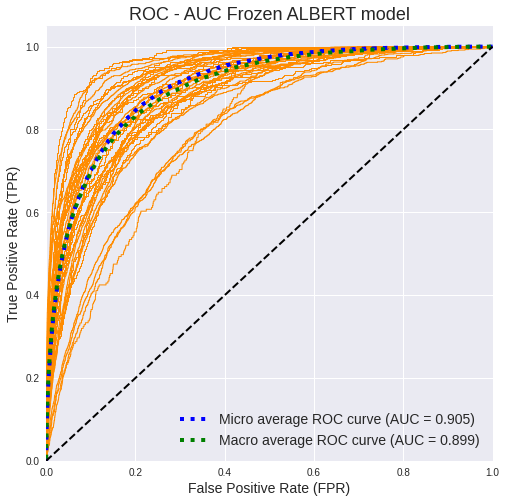

In [45]:
plt.figure(figsize=(8,8))

for i in range(len(df_val['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, layer_val_roc_auc[i]))
  plt.plot(layer_val_fpr[i], layer_val_tpr[i], color='darkorange',
          lw=1)

plt.plot(layer_val_fpr["micro"], layer_val_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(layer_val_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(layer_val_fpr["macro"], layer_val_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(layer_val_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC - AUC Frozen ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### TRAINED ALBERT model

AUC for class 0: 0.9711940261699881
AUC for class 1: 0.9522836820161102
AUC for class 2: 0.9689304770068335
AUC for class 3: 0.8994370010002918
AUC for class 4: 0.9609939417333262
AUC for class 5: 0.9457709568140964
AUC for class 6: 0.9265546531620835
AUC for class 7: 0.9251182658672872
AUC for class 8: 0.929031442981759
AUC for class 9: 0.9618863535858438
AUC for class 10: 0.9807638204874118
AUC for class 11: 0.9348357143563574
AUC for class 12: 0.9770151104839707
AUC for class 13: 0.9513551338389793
AUC for class 14: 0.9629266307248853
AUC for class 15: 0.9660059198568132
AUC for class 16: 0.951607448897749
AUC for class 17: 0.9576792654962061
AUC for class 18: 0.9619315230157656
AUC for class 19: 0.9503783036675136
AUC for class 20: 0.9517516819035433
AUC for class 21: 0.9551151391218275
AUC for class 22: 0.9578557487676466
AUC for class 23: 0.9509517760225332
AUC for class 24: 0.9741180050677953
AUC for class 25: 0.9274904991394417
AUC for class 26: 0.9735753564055146
AUC for class

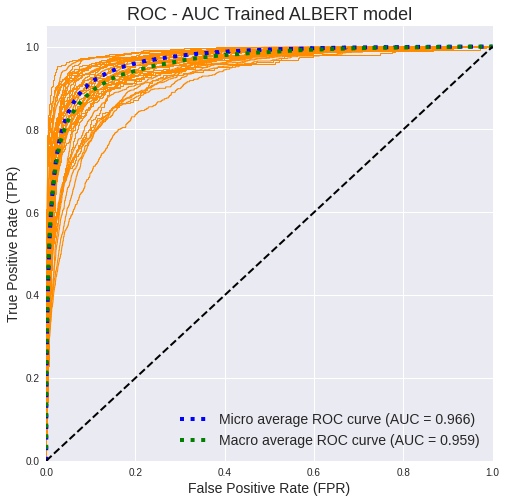

In [46]:
plt.figure(figsize=(8,8))

for i in range(len(df_val['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, full_val_roc_auc[i]))
  plt.plot(full_val_fpr[i], full_val_tpr[i], color='darkorange',
          lw=1)

plt.plot(full_val_fpr["micro"], full_val_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(full_val_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(full_val_fpr["macro"], full_val_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(full_val_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC - AUC Trained ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Siamese ALBERT model

AUC for class 0: 0.9540461738335474
AUC for class 1: 0.9544392810154433
AUC for class 2: 0.9488404173221547
AUC for class 3: 0.8807695524572082
AUC for class 4: 0.9646435560158133
AUC for class 5: 0.9433364448408972
AUC for class 6: 0.8848139236954535
AUC for class 7: 0.882627496422934
AUC for class 8: 0.9186693686660065
AUC for class 9: 0.9459310199389814
AUC for class 10: 0.9715259633821063
AUC for class 11: 0.9242200357029827
AUC for class 12: 0.9772992883368454
AUC for class 13: 0.9418235774221129
AUC for class 14: 0.9325482411657948
AUC for class 15: 0.9088961795620583
AUC for class 16: 0.9461720284284297
AUC for class 17: 0.9089803424590828
AUC for class 18: 0.9454156220355062
AUC for class 19: 0.9179801341580397
AUC for class 20: 0.9417691057134274
AUC for class 21: 0.939409204528289
AUC for class 22: 0.9466875807319405
AUC for class 23: 0.9504353059196305
AUC for class 24: 0.9599927016677257
AUC for class 25: 0.9151520708209085
AUC for class 26: 0.9661217921669064
AUC for class

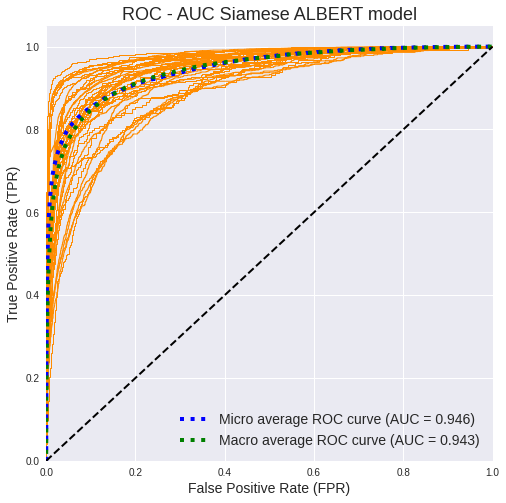

In [47]:
plt.figure(figsize=(8,8))

for i in range(len(df_val['category_id'].unique())):
  print('AUC for class {}: {}'.format(i, siamese_val_roc_auc[i]))
  plt.plot(siamese_val_fpr[i], siamese_val_tpr[i], color='darkorange',
          lw=1)

plt.plot(siamese_val_fpr["micro"], siamese_val_tpr["micro"],
         label='Micro average ROC curve (AUC = {0:0.3f})'
               ''.format(siamese_val_roc_auc["micro"]),
         color='blue', linestyle=':', linewidth=4)

plt.plot(siamese_val_fpr["macro"], siamese_val_tpr["macro"],
         label='Macro average ROC curve (AUC = {0:0.3f})'
               ''.format(siamese_val_roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC - AUC Siamese ALBERT model', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Embeddings

In [ ]:
# Save test embeddings for visualization in projector
np.savetxt("siamese_val_vecs.tsv", siamese_val_pred, delimiter='\t')

out_m = io.open('siamese_val_meta.tsv', 'w', encoding='utf-8')
for idx, value in enumerate(df_val['category']):
  [out_m.write(str(value) + "\n")]
out_m.close()


try:
  from google.colab import files
  files.download('siamese_val_vecs.tsv')
  files.download('siamese_val_meta.tsv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>